# UFC-Fight historical data from 1993 to 2019

### Compilado das lutas de UFC, estatísticas dos lutadores e informações

Criado em 1993 como uma organização profissional de artes marciais mistas (MMA), o UFC® revolucionou a indústria da luta e hoje se destaca tanto como uma marca global premium de esporte quanto como uma empresa de produção de conteúdo e o maior  provedor de eventos Pay-Per-View (PPV) do mundo.

O UFC segue uma história e uma tradição ricas de MMA competitivo que remonta ao Pancrácio, uma luta introduzida nos Jogos Olímpicos gregos no ano de 648 a.C. Há cerca de 80 anos, uma forma brasileira de MMA conhecida como Vale-Tudo despertou o interesse local pelo esporte. O UFC então introduziu o MMA organizado e sancionado nos Estados Unidos.

O objetivo era encontrar o "campeão supremo de luta" (Ultimate Fighting Champion) organizando um torneio de uma noite com os melhores atletas das diversas modalidades de artes marciais, Incluindo caratê, jiu-jítsu, boxe, kickboxing, grappling, wrestling, sumô e outros esportes de combate. O vencedor do torneio seria coroado o campeão.

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.colors import Normalize
from IPython.display import Image
import missingno as msno
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from sklearn import metrics

In [35]:
ufc_data = pd.read_csv('data/data.csv')
#ufc_preprocessed = pd.read_csv('data/preprocessed_data.csv', delimiter=',')
ufc_raw_fighter = pd.read_csv('data/raw_fighter_details.csv', delimiter=',')
#ufc_raw_total = pd.read_csv('data/raw_total_fight_data.csv', delimiter=';')

### Analisando arquivo preprocessed_data.csv

In [3]:
pd.set_option('display.max_columns', None)
ufc_preprocessed.tail()

NameError: name 'ufc_preprocessed' is not defined

In [136]:
ufc_preprocessed.shape

(3592, 160)

In [138]:
ufc_preprocessed.columns.to_list()

ufc_preprocessed = ufc_preprocessed[(ufc_preprocessed['weight_class_Open Weight']==0) &
                                    (ufc_preprocessed['weight_class_Catch Weight']==0)]

ufc_preprocessed

ufc_preprocessed.shape
#3534

ufc_preprocessed[['R_Weight_lbs','R_Height_cms','R_Reach_cms',
                  'B_Weight_lbs','B_Height_cms','B_Reach_cms']].count()

R_Weight_lbs    3534
R_Height_cms    3534
R_Reach_cms     3534
B_Weight_lbs    3534
B_Height_cms    3534
B_Reach_cms     3534
dtype: int64

### Analisando arquivo raw_fighter_details.csv

In [11]:
pd.set_option('display.max_columns', None)
ufc_raw_fighter.head()

fighter_name  Height    Weight Reach Stance  DOB
0   AJ Fonseca   5' 4"  145 lbs.   NaN    NaN  NaN
1  AJ Matthews  5' 11"  185 lbs.   NaN    NaN  NaN
2     AJ McKee  5' 10"  145 lbs.   NaN    NaN  NaN
3    AJ Siscoe   5' 7"  135 lbs.   NaN    NaN  NaN
4   Aalon Cruz   6' 0"  145 lbs.   NaN    NaN  NaN

In [12]:
ufc_raw_fighter.count()

fighter_name    3313
Height          3050
Weight          3238
Reach           1569
Stance          2439
DOB             2573
dtype: int64

Excluindo registros sem altura e/ou sem peso

In [36]:
ufc_raw_fighter = ufc_raw_fighter[ufc_raw_fighter['Height'].notna()]
ufc_raw_fighter = ufc_raw_fighter[ufc_raw_fighter['Weight'].notna()]
ufc_raw_fighter.count()

fighter_name    3044
Height          3044
Weight          3044
Reach           1568
Stance          2411
DOB             2519
dtype: int64

### Analisando arquivo raw_total_fight_data.csv

In [110]:
pd.set_option('display.max_columns', None)
ufc_raw_total.head()

R_fighter       B_fighter  R_KD  B_KD  R_SIG_STR. B_SIG_STR.  \
0          Henry Cejudo   Marlon Moraes     0     0   90 of 171  57 of 119   
1  Valentina Shevchenko     Jessica Eye     1     0     8 of 11    2 of 12   
2         Tony Ferguson  Donald Cerrone     0     0  104 of 200  68 of 185   
3         Jimmie Rivera        Petr Yan     0     2   73 of 192  56 of 189   
4           Tai Tuivasa   Blagoy Ivanov     0     1   64 of 144  73 of 123   

  R_SIG_STR_pct B_SIG_STR_pct R_TOTAL_STR. B_TOTAL_STR.    R_TD    B_TD  \
0           52%           47%    99 of 182    59 of 121  1 of 4  0 of 2   
1           72%           16%     37 of 40     42 of 52  2 of 2  0 of 0   
2           52%           36%   104 of 200    68 of 185  0 of 0  1 of 1   
3           38%           29%    76 of 195    58 of 192  0 of 3  1 of 3   
4           44%           59%    66 of 146    81 of 131  0 of 0  2 of 2   

  R_TD_pct B_TD_pct  R_SUB_ATT  B_SUB_ATT  R_PASS  B_PASS  R_REV  B_REV  \
0      25%       0%          1          0       1       0      0      0   
1     100%       0%          1          0       3       0      0      0   
2       0%     100%          0          0       0       0      0      0   
3       0%      33%          0          0       0       1      0      0   
4       0%     100%          0          0       0       0      0      0   

      R_HEAD     B_HEAD    R_BODY    B_BODY     R_LEG     B_LEG  R_DISTANCE  \
0  73 of 150   35 of 89  13 of 16    7 of 8    4 of 5  15 of 22   45 of 118   
1     4 of 5     0 of 7    4 of 6    0 of 2    0 of 0    2 of 3      5 of 8   
2  65 of 144  43 of 152  25 of 37  15 of 23  14 of 19  10 of 10  103 of 198   
3  42 of 145  40 of 166  15 of 24  13 of 19  16 of 23    3 of 4   60 of 173   
4  39 of 114  65 of 114    6 of 7    7 of 8  19 of 23    1 of 1   50 of 126   

  B_DISTANCE  R_CLINCH  B_CLINCH  R_GROUND B_GROUND                   win_by  \
0  54 of 116  19 of 23    2 of 2  26 of 30   1 of 1                   KO/TKO   
1    2 of 12    2 of 2    0 of 0    1 of 1   0 of 0                   KO/TKO   
2  68 of 184    1 of 2    0 of 1    0 of 0   0 of 0  TKO - Doctor's Stoppage   
3  42 of 167   9 of 15  10 of 12    4 of 4  4 of 10     Decision - Unanimous   
4  62 of 111  14 of 18    5 of 6    0 of 0   6 of 6     Decision - Unanimous   

   last_round last_round_time             Format          Referee  \
0           3            4:51  5 Rnd (5-5-5-5-5)     Marc Goddard   
1           2            0:26  5 Rnd (5-5-5-5-5)  Robert Madrigal   
2           2            5:00      3 Rnd (5-5-5)  Dan Miragliotta   
3           3            5:00      3 Rnd (5-5-5)  Kevin MacDonald   
4           3            5:00      3 Rnd (5-5-5)  Dan Miragliotta   

            date                location                        Fight_type  \
0  June 08, 2019  Chicago, Illinois, USA       UFC Bantamweight Title Bout   
1  June 08, 2019  Chicago, Illinois, USA  UFC Women's Flyweight Title Bout   
2  June 08, 2019  Chicago, Illinois, USA                  Lightweight Bout   
3  June 08, 2019  Chicago, Illinois, USA                 Bantamweight Bout   
4  June 08, 2019  Chicago, Illinois, USA                  Heavyweight Bout   

                 Winner  
0          Henry Cejudo  
1  Valentina Shevchenko  
2         Tony Ferguson  
3              Petr Yan  
4         Blagoy Ivanov

### Analisando arquivo data.csv

In [4]:
ufc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Columns: 145 entries, R_fighter to R_age
dtypes: bool(1), float64(134), int64(1), object(9)
memory usage: 5.7+ MB


In [110]:
pd.set_option('display.max_rows', None)
ufc_data.dtypes

R_fighter                               object
B_fighter                               object
Referee                                 object
date                            datetime64[ns]
location                                object
Winner                                category
title_bout                                bool
weight_class                            object
no_of_rounds                             int64
B_current_lose_streak                  float64
B_current_win_streak                   float64
B_avg_BODY_att                         float64
B_avg_BODY_landed                      float64
B_avg_CLINCH_att                       float64
B_avg_CLINCH_landed                    float64
B_avg_DISTANCE_att                     float64
B_avg_DISTANCE_landed                  float64
B_avg_GROUND_att                       float64
B_avg_GROUND_landed                    float64
B_avg_HEAD_att                         float64
B_avg_HEAD_landed                      float64
B_avg_KD     

In [5]:
pd.set_option('display.max_columns', None)
ufc_data.head()

R_fighter       B_fighter          Referee        date  \
0          Henry Cejudo   Marlon Moraes     Marc Goddard  2019-06-08   
1  Valentina Shevchenko     Jessica Eye  Robert Madrigal  2019-06-08   
2         Tony Ferguson  Donald Cerrone  Dan Miragliotta  2019-06-08   
3         Jimmie Rivera        Petr Yan  Kevin MacDonald  2019-06-08   
4           Tai Tuivasa   Blagoy Ivanov  Dan Miragliotta  2019-06-08   

                 location Winner  title_bout       weight_class  no_of_rounds  \
0  Chicago, Illinois, USA    Red        True       Bantamweight             5   
1  Chicago, Illinois, USA    Red        True  Women's Flyweight             5   
2  Chicago, Illinois, USA    Red       False        Lightweight             3   
3  Chicago, Illinois, USA   Blue       False       Bantamweight             3   
4  Chicago, Illinois, USA   Blue       False        Heavyweight             3   

   B_current_lose_streak  B_current_win_streak  B_draw  B_avg_BODY_att  \
0                    0.0                   4.0     0.0        9.200000   
1                    0.0                   3.0     0.0       14.600000   
2                    0.0                   3.0     0.0       15.354839   
3                    0.0                   4.0     0.0       17.000000   
4                    0.0                   1.0     0.0       17.000000   

   B_avg_BODY_landed  B_avg_CLINCH_att  B_avg_CLINCH_landed  \
0           6.000000          0.200000             0.000000   
1           9.100000         11.800000             7.300000   
2          11.322581          6.741935             4.387097   
3          14.000000         13.750000            11.000000   
4          14.500000          2.500000             2.000000   

   B_avg_DISTANCE_att  B_avg_DISTANCE_landed  B_avg_GROUND_att  \
0           62.600000              20.600000          2.600000   
1          124.700000              42.100000          2.400000   
2           84.741935              38.580645          5.516129   
3          109.500000              48.750000         13.000000   
4          201.000000              59.500000          0.000000   

   B_avg_GROUND_landed  B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  \
0             2.000000       48.600000          11.200000  0.800000   
1             1.900000      112.000000          32.000000  0.000000   
2             3.806452       67.645161          23.258065  0.645161   
3            10.500000      116.250000          53.750000  0.500000   
4             0.000000      184.500000          45.000000  0.000000   

   B_avg_LEG_att  B_avg_LEG_landed  B_avg_PASS  B_avg_REV  B_avg_SIG_STR_att  \
0            7.6          5.400000    0.400000   0.000000              65.40   
1           12.3         10.200000    0.800000   0.000000             138.90   
2           14.0         12.193548    0.935484   0.096774              97.00   
3            3.0          2.500000    0.500000   0.250000             136.25   
4            2.0          2.000000    0.000000   0.000000             203.50   

   B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_att  \
0             22.600000           0.466000       0.400000       0.80000   
1             51.300000           0.399000       0.700000       1.00000   
2             46.774194           0.496129       0.354839       2.16129   
3             70.250000           0.550000       0.250000       2.50000   
4             61.500000           0.310000       0.000000       0.00000   

   B_avg_TD_landed  B_avg_TD_pct  B_avg_TOTAL_STR_att  B_avg_TOTAL_STR_landed  \
0         0.200000      0.100000            66.400000               23.600000   
1         0.500000      0.225000           158.700000               69.600000   
2         0.677419      0.295484           103.709677               52.548387   
3         1.250000      0.287500           154.750000               86.750000   
4         0.000000      0.000000           204.000000               62.000000   

   B_longest_win_streak  B_

In [6]:
pd.set_option('display.max_columns', None)
ufc_data.tail()

R_fighter      B_fighter               Referee        date  \
5139  Gerard Gordeau   Kevin Rosier  Joao Alberto Barreto  1993-11-12   
5140    Ken Shamrock  Patrick Smith  Joao Alberto Barreto  1993-11-12   
5141    Royce Gracie  Art Jimmerson  Joao Alberto Barreto  1993-11-12   
5142    Kevin Rosier   Zane Frazier  Joao Alberto Barreto  1993-11-12   
5143  Gerard Gordeau     Teila Tuli  Joao Alberto Barreto  1993-11-12   

                   location Winner  title_bout weight_class  no_of_rounds  \
5139  Denver, Colorado, USA    Red       False  Open Weight             1   
5140  Denver, Colorado, USA    Red       False  Open Weight             1   
5141  Denver, Colorado, USA    Red       False  Open Weight             1   
5142  Denver, Colorado, USA    Red       False  Open Weight             1   
5143  Denver, Colorado, USA    Red       False  Open Weight             1   

      B_current_lose_streak  B_current_win_streak  B_draw  B_avg_BODY_att  \
5139                    0.0                   1.0     0.0             4.0   
5140                    0.0                   0.0     0.0             NaN   
5141                    0.0                   0.0     0.0             NaN   
5142                    0.0                   0.0     0.0             NaN   
5143                    0.0                   0.0     0.0             NaN   

      B_avg_BODY_landed  B_avg_CLINCH_att  B_avg_CLINCH_landed  \
5139                3.0               9.0                  4.0   
5140                NaN               NaN                  NaN   
5141                NaN               NaN                  NaN   
5142                NaN               NaN                  NaN   
5143                NaN               NaN                  NaN   

      B_avg_DISTANCE_att  B_avg_DISTANCE_landed  B_avg_GROUND_att  \
5139                10.0                    4.0               8.0   
5140                 NaN                    NaN               NaN   
5141                 NaN                    NaN               NaN   
5142                 NaN                    NaN               NaN   
5143                 NaN                    NaN               NaN   

      B_avg_GROUND_landed  B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  \
5139                  7.0            23.0               12.0       2.0   
5140                  NaN             NaN                NaN       NaN   
5141                  NaN             NaN                NaN       NaN   
5142                  NaN             NaN                NaN       NaN   
5143                  NaN             NaN                NaN       NaN   

      B_avg_LEG_att  B_avg_LEG_landed  B_avg_PASS  B_avg_REV  \
5139            0.0               0.0         0.0        0.0   
5140            NaN               NaN         NaN        NaN   
5141            NaN               NaN         NaN        NaN   
5142            NaN               NaN         NaN        NaN   
5143            NaN               NaN         NaN        NaN   

      B_avg_SIG_STR_att  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
5139               27.0                  15.0               0.55   
5140                NaN                   NaN                NaN   
5141                NaN                   NaN                NaN   
5142                NaN                   NaN                NaN   
5143                NaN                   NaN                NaN   

      B_avg_SUB_ATT  B_avg_TD_att  B_avg_TD_landed  B_avg_TD_pct  \
5139            0.0           0.0              0.0           0.0   
5140            NaN           NaN              NaN           NaN   
5141            NaN           NaN              NaN           NaN   
5142            NaN           NaN              NaN           NaN   
5143            NaN           NaN              NaN           NaN   

      B_avg_TOTAL_STR_att  B_avg_TOTAL_STR_landed  B_longest_win_streak  \
5139                 53.0                    38.0                   1.0   
5140                  NaN           

In [7]:
ufc_data.shape
#5144

(5144, 145)

Substituindo campos vazios por Nan, convertendo a data para datetime, e arrendondando tudo para 3 casas decimais

In [37]:
ufc_data = ufc_data.replace(r'^\s*$', np.nan, regex=True) # replace empty string with nan
ufc_data = ufc_data.fillna(np.nan) # Fill empty and NaNs values with NaN
ufc_data["date"] = pd.to_datetime(ufc_data["date"]) # date as datetime
ufc_data = ufc_data.round(3) # format data

In [116]:
pd.set_option('display.max_columns', None)
ufc_data.tail()

R_fighter      B_fighter               Referee       date  \
5139  Gerard Gordeau   Kevin Rosier  Joao Alberto Barreto 1993-11-12   
5140    Ken Shamrock  Patrick Smith  Joao Alberto Barreto 1993-11-12   
5141    Royce Gracie  Art Jimmerson  Joao Alberto Barreto 1993-11-12   
5142    Kevin Rosier   Zane Frazier  Joao Alberto Barreto 1993-11-12   
5143  Gerard Gordeau     Teila Tuli  Joao Alberto Barreto 1993-11-12   

                   location Winner  title_bout weight_class  no_of_rounds  \
5139  Denver, Colorado, USA    Red       False  Open Weight             1   
5140  Denver, Colorado, USA    Red       False  Open Weight             1   
5141  Denver, Colorado, USA    Red       False  Open Weight             1   
5142  Denver, Colorado, USA    Red       False  Open Weight             1   
5143  Denver, Colorado, USA    Red       False  Open Weight             1   

      B_current_lose_streak  B_current_win_streak  B_draw  B_avg_BODY_att  \
5139                    0.0                   1.0     0.0             4.0   
5140                    0.0                   0.0     0.0             NaN   
5141                    0.0                   0.0     0.0             NaN   
5142                    0.0                   0.0     0.0             NaN   
5143                    0.0                   0.0     0.0             NaN   

      B_avg_BODY_landed  B_avg_CLINCH_att  B_avg_CLINCH_landed  \
5139                3.0               9.0                  4.0   
5140                NaN               NaN                  NaN   
5141                NaN               NaN                  NaN   
5142                NaN               NaN                  NaN   
5143                NaN               NaN                  NaN   

      B_avg_DISTANCE_att  B_avg_DISTANCE_landed  B_avg_GROUND_att  \
5139                10.0                    4.0               8.0   
5140                 NaN                    NaN               NaN   
5141                 NaN                    NaN               NaN   
5142                 NaN                    NaN               NaN   
5143                 NaN                    NaN               NaN   

      B_avg_GROUND_landed  B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  \
5139                  7.0            23.0               12.0       2.0   
5140                  NaN             NaN                NaN       NaN   
5141                  NaN             NaN                NaN       NaN   
5142                  NaN             NaN                NaN       NaN   
5143                  NaN             NaN                NaN       NaN   

      B_avg_LEG_att  B_avg_LEG_landed  B_avg_PASS  B_avg_REV  \
5139            0.0               0.0         0.0        0.0   
5140            NaN               NaN         NaN        NaN   
5141            NaN               NaN         NaN        NaN   
5142            NaN               NaN         NaN        NaN   
5143            NaN               NaN         NaN        NaN   

      B_avg_SIG_STR_att  B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  \
5139               27.0                  15.0               0.55   
5140                NaN                   NaN                NaN   
5141                NaN                   NaN                NaN   
5142                NaN                   NaN                NaN   
5143                NaN                   NaN                NaN   

      B_avg_SUB_ATT  B_avg_TD_att  B_avg_TD_landed  B_avg_TD_pct  \
5139            0.0           0.0              0.0           0.0   
5140            NaN           NaN              NaN           NaN   
5141            NaN           NaN              NaN           NaN   
5142            NaN           NaN              NaN           NaN   
5143            NaN           NaN              NaN           NaN   

      B_avg_TOTAL_STR_att  B_avg_TOTAL_STR_landed  B_longest_win_streak  \
5139                 53.0                    38.0                   1.0   
5140                  NaN                 

In [8]:
ufc_data.columns.to_list()

['R_fighter',
 'B_fighter',
 'Referee',
 'date',
 'location',
 'Winner',
 'title_bout',
 'weight_class',
 'no_of_rounds',
 'B_current_lose_streak',
 'B_current_win_streak',
 'B_draw',
 'B_avg_BODY_att',
 'B_avg_BODY_landed',
 'B_avg_CLINCH_att',
 'B_avg_CLINCH_landed',
 'B_avg_DISTANCE_att',
 'B_avg_DISTANCE_landed',
 'B_avg_GROUND_att',
 'B_avg_GROUND_landed',
 'B_avg_HEAD_att',
 'B_avg_HEAD_landed',
 'B_avg_KD',
 'B_avg_LEG_att',
 'B_avg_LEG_landed',
 'B_avg_PASS',
 'B_avg_REV',
 'B_avg_SIG_STR_att',
 'B_avg_SIG_STR_landed',
 'B_avg_SIG_STR_pct',
 'B_avg_SUB_ATT',
 'B_avg_TD_att',
 'B_avg_TD_landed',
 'B_avg_TD_pct',
 'B_avg_TOTAL_STR_att',
 'B_avg_TOTAL_STR_landed',
 'B_longest_win_streak',
 'B_losses',
 'B_avg_opp_BODY_att',
 'B_avg_opp_BODY_landed',
 'B_avg_opp_CLINCH_att',
 'B_avg_opp_CLINCH_landed',
 'B_avg_opp_DISTANCE_att',
 'B_avg_opp_DISTANCE_landed',
 'B_avg_opp_GROUND_att',
 'B_avg_opp_GROUND_landed',
 'B_avg_opp_HEAD_att',
 'B_avg_opp_HEAD_landed',
 'B_avg_opp_KD',
 'B_av

In [9]:
ufc_data[['R_Weight_lbs','R_Height_cms','R_Reach_cms',
          'B_Weight_lbs','B_Height_cms','B_Reach_cms']].count()

R_Weight_lbs    5141
R_Height_cms    5140
R_Reach_cms     4828
B_Weight_lbs    5138
B_Height_cms    5136
B_Reach_cms     4478
dtype: int64

In [10]:
df_R_Height_na = ufc_data[ufc_data['R_Height_cms'].isna()][['R_fighter','R_Height_cms']]
df_R_Height_na.shape
#4
# Inner join do DataFrame 'df_R_Height_na' com o DataFrame 'ufc_raw_fighter'.
df_R_Height=pd.merge(df_R_Height_na, ufc_raw_fighter, how='inner', left_on='R_fighter', right_on='fighter_name')
df_R_Height
#3
df_R_Height[df_R_Height['Height'].notna()].shape
#0

NameError: name 'ufc_raw_fighter' is not defined

In [153]:
df_R_Reach_na = ufc_data[ufc_data['R_Reach_cms'].isna()][['R_fighter','R_Reach_cms']]
df_R_Reach_na.shape
#316
# Inner join do DataFrame 'df_R_Height_na' com o DataFrame 'ufc_raw_fighter'.
df_R_Reach=pd.merge(df_R_Reach_na, ufc_raw_fighter, how='inner', left_on='R_fighter', right_on='fighter_name')
df_R_Reach.shape
315
df_R_Reach[df_R_Reach['Reach'].notna()].shape
#0

(0, 8)

In [154]:
df_B_Height_na = ufc_data[ufc_data['B_Height_cms'].isna()][['B_fighter','B_Height_cms']]
df_B_Height_na.shape
#8
# Inner join do DataFrame 'df_R_Height_na' com o DataFrame 'ufc_raw_fighter'.
df_B_Height=pd.merge(df_B_Height_na, ufc_raw_fighter, how='inner', left_on='B_fighter', right_on='fighter_name')
df_B_Height.shape
#8
df_B_Height[df_B_Height['Height'].notna()].shape
#0

(0, 8)

In [156]:
df_B_Reach_na = ufc_data[ufc_data['B_Reach_cms'].isna()][['B_fighter','B_Reach_cms']]
df_B_Reach_na.shape
#666
# Inner join do DataFrame 'df_R_Height_na' com o DataFrame 'ufc_raw_fighter'.
df_B_Reach=pd.merge(df_B_Reach_na, ufc_raw_fighter, how='inner', left_on='B_fighter', right_on='fighter_name')
df_B_Reach.shape
#666
df_B_Reach[df_B_Reach['Reach'].notna()].shape
#0

(0, 8)

### Divisões de peso
O UFC se divide nessas categorias de pesos:

* Peso Palha (Strawweight) - até 52,2 kg /115 lb (Feminino)
* Peso Mosca (Flyweight) - até 56,7 kg / 125 lb (Masculino e Feminino)
* Peso Galo (Bantamweight) - até 61,2 kg / 135 lb (Masculino e Feminino)
* Peso Pena (Featherweight) - até 65,8 kg / 145 lb (Masculino e Feminino)
* Peso Leve (Lightweight) - até 70,3 kg / 155 lb
* Peso Meio-Médio (Welterweight) - até 77,1 kg / 170 lb
* Peso Médio (Middleweight) - até 83,9 kg / 185 lb
* Peso Meio-Pesado (Light Heavyweight) - até 92,9 kg / 205 lb
* Peso Pesado (Heavyweight) - até 120,2 kg / 265 lb

No começo do UFC não havia divisão de categorias por peso e o combate acontece em um round único sem tempo. Na base de dados, essas lutas receberam a nomeclatura de Open Weight e Catch Weight. Para a criação de um melhor modelo, essas categorias serão removidas da base.

# CATEGORIZAR EM MASCULINO E FEMININO - IMPORTANTE!

In [4]:
ufc_data.groupby('weight_class')['weight_class'].count()

weight_class
Bantamweight             379
Catch Weight              38
Featherweight            442
Flyweight                187
Heavyweight              507
Light Heavyweight        502
Lightweight              989
Middleweight             725
Open Weight               92
Welterweight             969
Women's Bantamweight     111
Women's Featherweight     10
Women's Flyweight         50
Women's Strawweight      143
Name: weight_class, dtype: int64

In [38]:
weight_class_to_be_removed = ['Open Weight', 'Catch Weight']

ufc_data = ufc_data[~ufc_data['weight_class'].isin(weight_class_to_be_removed)]

In [46]:
ufc_data.tail()
ufc_data.shape

(5014, 145)

In [6]:
ufc_data.groupby('weight_class')['weight_class'].count()

weight_class
Bantamweight             379
Featherweight            442
Flyweight                187
Heavyweight              507
Light Heavyweight        502
Lightweight              989
Middleweight             725
Welterweight             969
Women's Bantamweight     111
Women's Featherweight     10
Women's Flyweight         50
Women's Strawweight      143
Name: weight_class, dtype: int64

In [85]:
ufc_data.groupby('Winner')['Winner'].count()

Winner
Blue    1586
Draw      81
Red     3347
Name: Winner, dtype: int64

Removendo os empates:

In [39]:
ufc_data=ufc_data[ufc_data['Winner']!='Draw']
ufc_data.groupby('Winner')['Winner'].count()

Winner
Blue    1586
Red     3347
Name: Winner, dtype: int64

In [40]:
del ufc_data['R_draw']
del ufc_data['B_draw']

In [62]:
ufc_data.groupby('B_Stance')['B_Stance'].count()

B_Stance
Open Stance       8
Orthodox       3690
Sideways          1
Southpaw        937
Switch          157
Name: B_Stance, dtype: int64

In [63]:
ufc_data.groupby('R_Stance')['R_Stance'].count()

R_Stance
Open Stance      15
Orthodox       3659
Southpaw        990
Switch          142
Name: R_Stance, dtype: int64

In [121]:
ufc_data[['R_Weight_lbs','R_Height_cms','R_Reach_cms','R_Stance',
          'B_Weight_lbs','B_Height_cms','B_Reach_cms','B_Stance']].count()

R_Weight_lbs    4931
R_Height_cms    4930
R_Reach_cms     4720
R_Stance        4806
B_Weight_lbs    4929
B_Height_cms    4927
B_Reach_cms     4384
B_Stance        4793
dtype: int64

Categorizando Stance

In [41]:
ufc_data['B_Stance'] = ufc_data['B_Stance'].astype('category')
ufc_data['R_Stance'] = ufc_data['R_Stance'].astype('category')

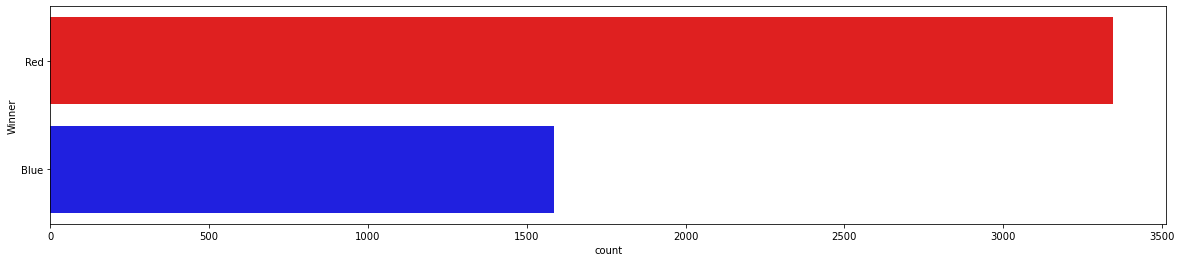

In [42]:
plt.figure(figsize=(20,4))
sns.countplot(y="Winner", data=ufc_data,palette=["Red","Blue"])

Vemos no gráfico acima que a cor é relevante!

In [43]:
# Blue = 0 / Red = 1
ufc_data['Winner'] = ufc_data['Winner'].replace(['Blue','Red'], [0,1]).values
ufc_data['Winner'] = ufc_data['Winner'].astype('category')
ufc_data['B_color'] = 0
ufc_data['B_color'] = ufc_data['B_color'].astype('category')
ufc_data['R_color'] = 1
ufc_data['R_color'] = ufc_data['R_color'].astype('category')

In [44]:
B_columns = ['Winner'] + ufc_data.filter(regex='^B_',axis=1).columns.to_list()
ufc_data_B = ufc_data[B_columns]

In [45]:
R_columns = ['Winner'] + ufc_data.filter(regex='^R_',axis=1).columns.to_list()
ufc_data_R = ufc_data[R_columns]

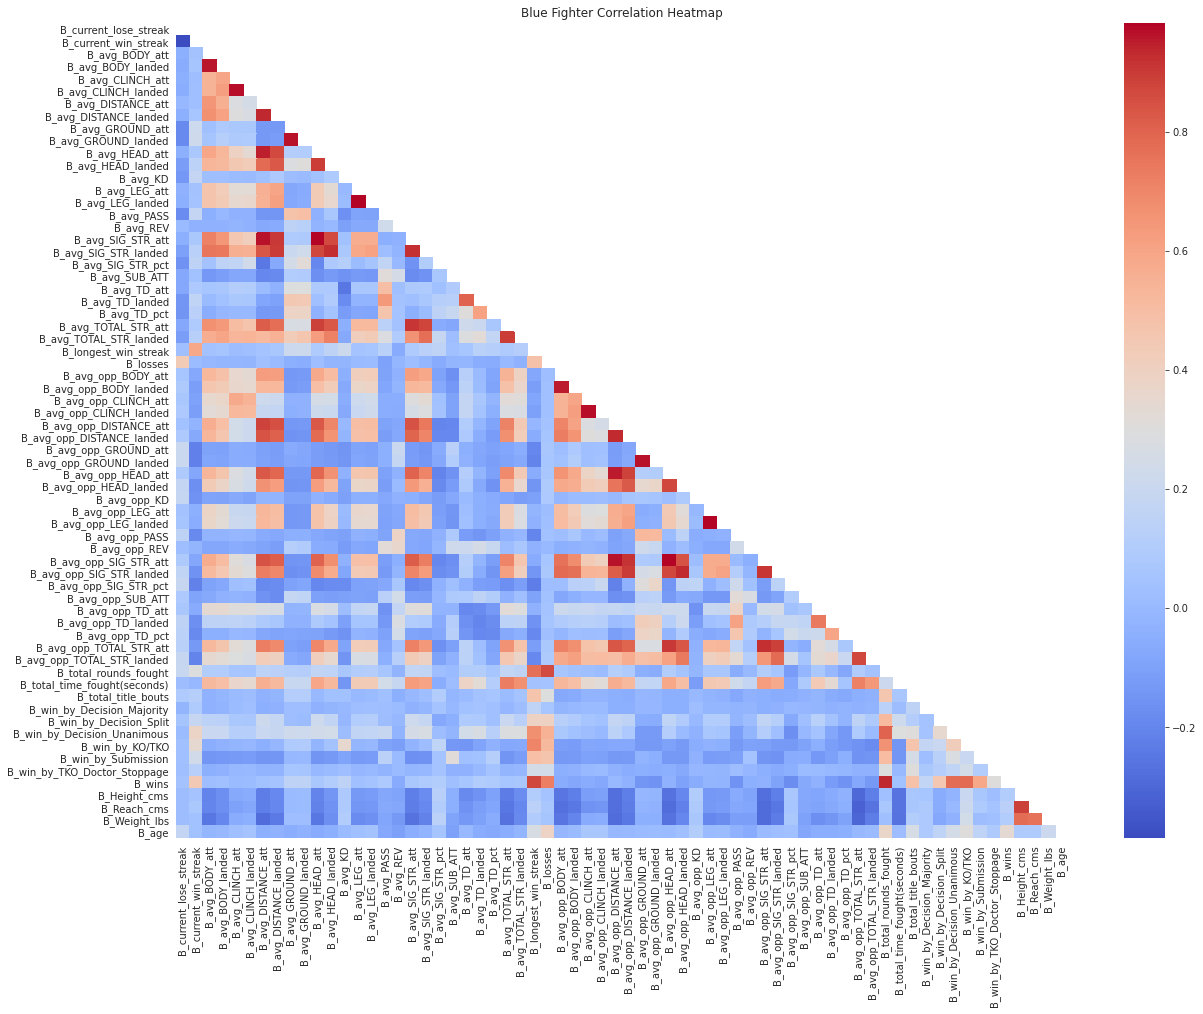

In [15]:
plt.figure(figsize=(20,15))
corr = ufc_data_B.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False,cmap="coolwarm").set_title("Blue Fighter Correlation Heatmap")

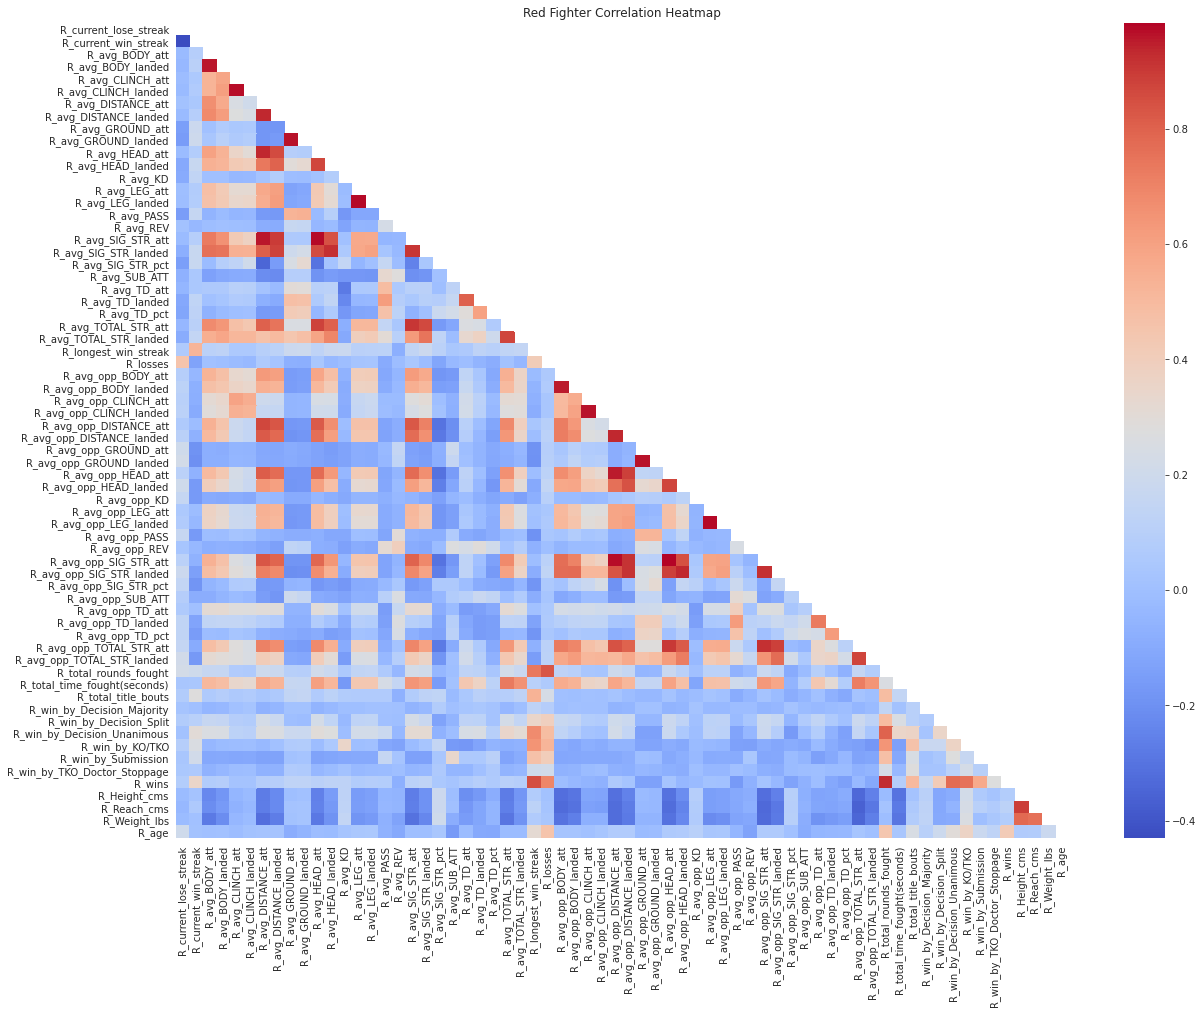

In [16]:
plt.figure(figsize=(20,15))
corr = ufc_data_R.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False,cmap="coolwarm").set_title("Red Fighter Correlation Heatmap")

In [17]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
corr

R_current_lose_streak  R_current_win_streak  \
R_current_lose_streak               1.000000             -0.430508   
R_current_win_streak               -0.430508              1.000000   
...                                      ...                   ...   
R_Weight_lbs                       -0.016477              0.009786   
R_age                               0.204568              0.013792   

                       R_avg_BODY_att  R_avg_BODY_landed  R_avg_CLINCH_att  \
R_current_lose_streak       -0.022768          -0.037810         -0.012874   
R_current_win_streak         0.089008           0.108970          0.054890   
...                               ...                ...               ...   
R_Weight_lbs                -0.275835          -0.213028         -0.042874   
R_age                        0.003626           0.008598         -0.012622   

                       R_avg_CLINCH_landed  R_avg_DISTANCE_att  \
R_current_lose_streak            -0.026164            0.014713   
R_current_win_streak              0.070481            0.045415   
...                                    ...                 ...   
R_Weight_lbs                     -0.020162           -0.316645   
R_age                             0.015380            0.017850   

                       R_avg_DISTANCE_landed  R_avg_GROUND_att  \
R_current_lose_streak              -0.024112         -0.147273   
R_current_win_streak                0.090587          0.183242   
...                                      ...               ...   
R_Weight_lbs                       -0.270118          0.014992   
R_age                               0.018936         -0.087940   

                       R_avg_GROUND_landed  R_avg_HEAD_att  R_avg_HEAD_landed  \
R_current_lose_streak            -0.155351       -0.020154          -0.101863   
R_current_win_streak              0.195836        0.082786           0.167968   
...                                    ...             ...                ...   
R_Weight_lbs                      0.022642       -0.286518          -0.188394   
R_age                            -0.060278       -0.013992          -0.021559   

                       R_avg_KD  R_avg_LEG_att  R_avg_LEG_landed  R_avg_PASS  \
R_current_lose_streak -0.094132      -0.001586         -0.005534   -0.151596   
R_current_win_streak   0.139688       0.074051          0.078771    0.158069   
...                         ...            ...               ...         ...   
R_Weight_lbs           0.149090      -0.185020         -0.163576   -0.069530   
R_age                  0.025903       0.044489          0.047763   -0.064739   

                       R_avg_REV  R_avg_SIG_STR_att  R_avg_SIG_STR_landed  \
R_current_lose_streak   0.014385          -0.020459             -0.082126   
R_current_win_streak   -0.034729           0.092959              0.166742   
...                          ...                ...                   ...   
R_Weight_lbs           -0.128862          -0.306181             -0.232031   
R_age                  -0.101833          -0.004447              0.000173   

                       R_avg_SIG_STR_pct  R_avg_SUB_ATT  R_avg_TD_att  \
R_current_lose_streak          -0.143433      -0.068556     -0.046711   
R_current_win_streak            0.169980       0.049998      0.050026   
...                                  ...            ...           ...   
R_Weight_lbs                    0.204194      -0.086785     -0.155640   
R_age                           0.034139      -0.161885     -0.018013   

                       R_avg_TD_landed  R_avg_TD_pct  R_avg_TOTAL_STR_att  \
R_current_lose_streak        -0.107977     -0.118760            -0.041979   
R_current_win_streak          0.136628      0.122665             0.105599   
...                                ...           ...                  ...   
R_Weight_lbs                 -0.120233     -0.054634            -0.297096   
R_age                        -0.099430     -0.105579            -0.017492   

      

In [18]:
df = ufc_data_B.corr()
df[df['Winner']<-0.15]['Winner']

KeyError: 'Winner'

In [19]:
df = ufc_data_R.corr()
df[df['Winner']<-0.15]['Winner']

KeyError: 'Winner'

In [46]:
important = ['date',
 'B_fighter',
 'R_fighter',
 'Winner',
 'B_avg_DISTANCE_att',
 'B_avg_DISTANCE_landed',
 'B_avg_SIG_STR_att',
 'B_current_lose_streak',
 'B_current_win_streak',
 'B_longest_win_streak',
 'B_losses',
 'B_total_rounds_fought',
 'B_total_title_bouts',
 'B_win_by_Decision_Majority',
 'B_win_by_Decision_Split',
 'B_win_by_Decision_Unanimous',
 'B_win_by_KO/TKO',
 'B_win_by_Submission',
 'B_win_by_TKO_Doctor_Stoppage',
 'B_wins',
 'B_Stance',
 'B_Height_cms',
 'B_Reach_cms',
 'B_Weight_lbs',
 'R_avg_DISTANCE_att',
 'R_avg_DISTANCE_landed',
 'R_avg_SIG_STR_att',
 'R_current_lose_streak',
 'R_current_win_streak',
 'R_longest_win_streak',
 'R_losses',
 'R_total_rounds_fought',
 'R_total_title_bouts',
 'R_win_by_Decision_Majority',
 'R_win_by_Decision_Split',
 'R_win_by_Decision_Unanimous',
 'R_win_by_KO/TKO',
 'R_win_by_Submission',
 'R_win_by_TKO_Doctor_Stoppage',
 'R_wins',
 'R_Stance',
 'R_Height_cms',
 'R_Reach_cms',
 'R_Weight_lbs',
 'B_age',
 'R_age']

ufc_data_clean = ufc_data[important]


In [47]:
B_columns_clean = ['Winner'] + ufc_data_clean.filter(regex='^B_',axis=1).columns.to_list()
ufc_data_B_clean = ufc_data_clean[B_columns_clean]

In [48]:
R_columns_clean = ['Winner'] + ufc_data_clean.filter(regex='^R_',axis=1).columns.to_list()
ufc_data_R_clean = ufc_data_clean[R_columns_clean]

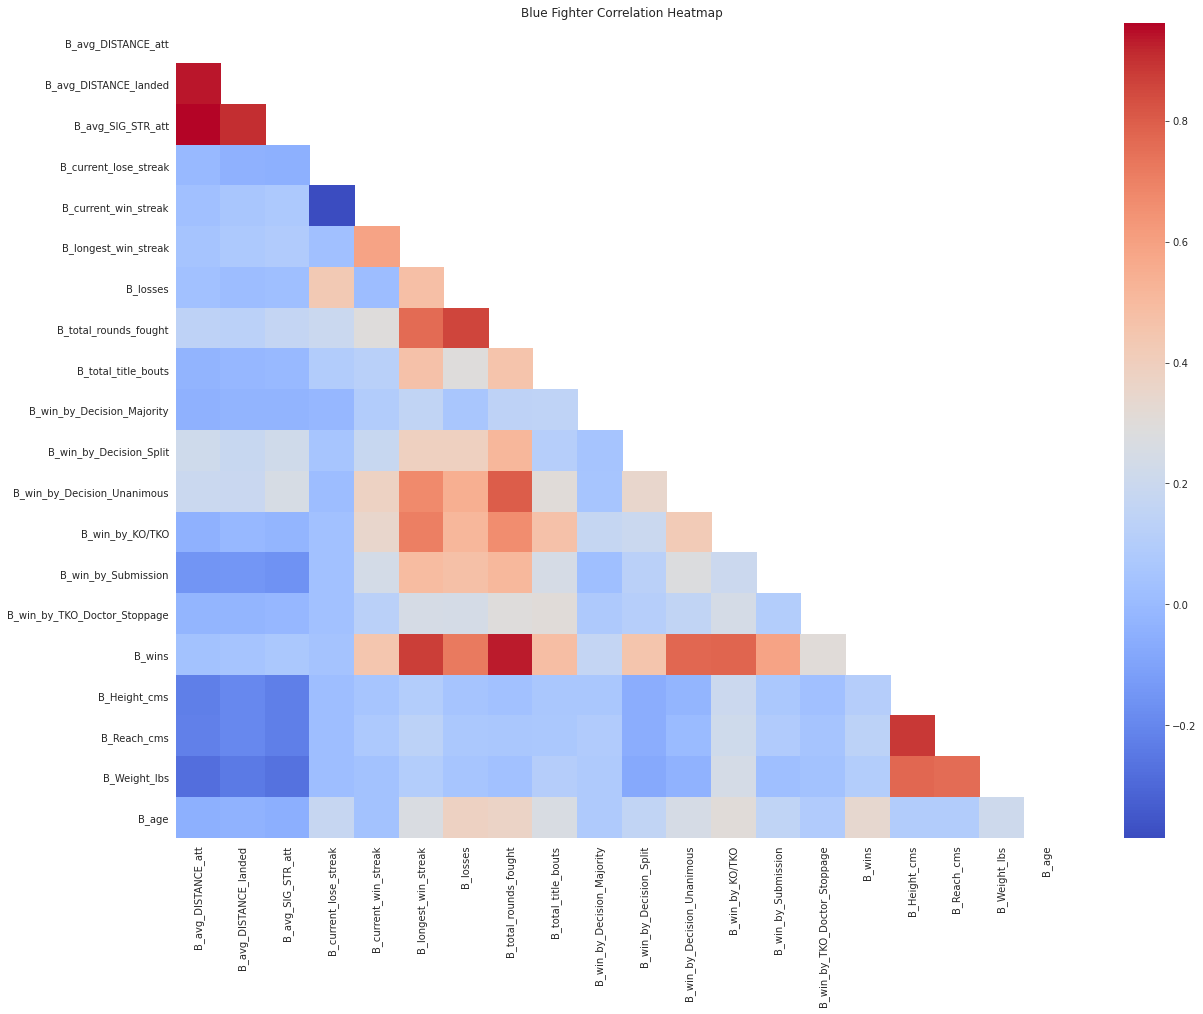

In [49]:
plt.figure(figsize=(20,15))
corr = ufc_data_B_clean.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False,cmap="coolwarm").set_title("Blue Fighter Correlation Heatmap")

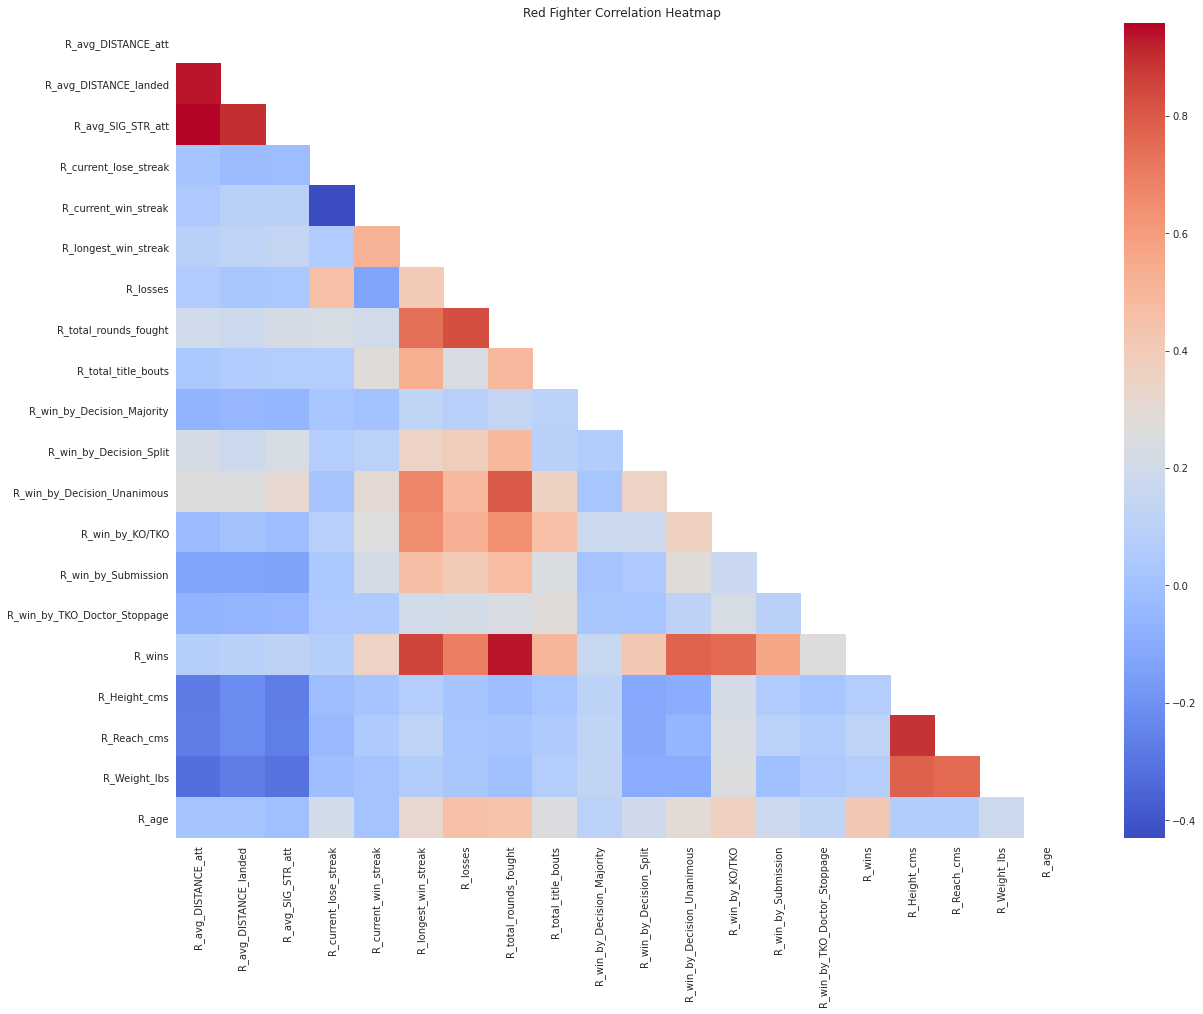

In [24]:
plt.figure(figsize=(20,15))
corr = ufc_data_R_clean.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=False,cmap="coolwarm").set_title("Red Fighter Correlation Heatmap")

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
corr

R_avg_DISTANCE_att  R_avg_DISTANCE_landed  \
R_avg_DISTANCE_att                      1.000000               0.935425   
R_avg_DISTANCE_landed                   0.935425               1.000000   
R_avg_SIG_STR_att                       0.958380               0.900105   
R_current_lose_streak                   0.014713              -0.024112   
R_current_win_streak                    0.045415               0.090587   
R_longest_win_streak                    0.094905               0.119565   
R_losses                                0.062005               0.027064   
R_total_rounds_fought                   0.198153               0.178826   
R_total_title_bouts                     0.038261               0.059202   
R_win_by_Decision_Majority             -0.062837              -0.047187   
R_win_by_Decision_Split                 0.224117               0.178044   
R_win_by_Decision_Unanimous             0.267157               0.256035   
R_win_by_KO/TKO                        -0.032280               0.006758   
R_win_by_Submission                    -0.126743              -0.130651   
R_win_by_TKO_Doctor_Stoppage           -0.063884              -0.061248   
R_wins                                  0.084815               0.091037   
R_Height_cms                           -0.274079              -0.221746   
R_Reach_cms                            -0.268384              -0.223658   
R_Weight_lbs                           -0.316645              -0.270118   
R_age                                   0.017850               0.018936   

                              R_avg_SIG_STR_att  R_current_lose_streak  \
R_avg_DISTANCE_att                     0.958380               0.014713   
R_avg_DISTANCE_landed                  0.900105              -0.024112   
R_avg_SIG_STR_att                      1.000000              -0.020459   
R_current_lose_streak                 -0.020459               1.000000   
R_current_win_streak                   0.092959              -0.430508   
R_longest_win_streak                   0.140071               0.061786   
R_losses                               0.040257               0.456464   
R_total_rounds_fought                  0.221775               0.226364   
R_total_title_bouts                    0.077624               0.076767   
R_win_by_Decision_Majority            -0.055216               0.023650   
R_win_by_Decision_Split                0.228498               0.077148   
R_win_by_Decision_Unanimous            0.316225               0.014771   
R_win_by_KO/TKO                       -0.017455               0.089127   
R_win_by_Submission                   -0.137466               0.037473   
R_win_by_TKO_Doctor_Stoppage          -0.048439               0.046145   
R_wins                                 0.112704               0.079957   
R_Height_cms                          -0.269947              -0.021521   
R_Reach_cms                           -0.263605              -0.037172   
R_Weight_lbs                          -0.306181              -0.016477   
R_age                                 -0.004447               0.204568   

                              R_current_win_streak  R_longest_win_streak  \
R_avg_DISTANCE_att                        0.045415              0.094905   
R_avg_DISTANCE_landed                     0.090587              0.119565   
R_avg_SIG_STR_att                         0.092959              0.140071   
R_current_lose_streak                    -0.430508              0.061786   
R_current_win_streak                      1.000000              0.521537   
R_longest_win_streak                      0.521537              1.000000   
R_losses                                 -0.127968              0.409375   
R_total_rounds_fought                     0.202534              0.740383   
R_total_title_bouts                       0.280266              0.531176   
R_win_by_Decision_Majority                0.002989              0.126805   
R_win_by_Decision_Split                   0.104646             

Each square shows the correlation between the variables on each axis. Correlation ranges from -1 to +1. Values closer to zero means there is no linear trend between the two variables. The close to 1 the correlation is the more positively correlated they are; that is as one increases so does the other and the closer to 1 the stronger this relationship is. A correlation closer to -1 is similar, but instead of both increasing one variable will decrease as the other increases. The diagonals are all 1/dark green because those squares are correlating each variable to itself (so it's a perfect correlation). For the rest the larger the number and darker the color the higher the correlation between the two variables. The plot is also symmetrical about the diagonal since the same two variables are being paired together in those squares.

Dos pares de variáveis com correlação alta, manter só uma delas no modelo para evitar ruídos.

In [26]:
sns_plot = sns.pairplot(ufc_data_clean, palette='bwr', kind='scatter', diag_kind='hist', diag_kws={'alpha':0.5}, hue='Winner')
sns_plot.savefig("pairplot.png")

plt.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

NameError: name 'Image' is not defined

<Figure size 7243.5x7200 with 0 Axes>

In [50]:
missing = round(ufc_data.isnull().sum()/ufc_data.shape[0]*100,2)
print(f'% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')


% Missing in 109 Features:
Referee                          0.45
B_avg_BODY_att                  23.90
B_avg_BODY_landed               23.90
B_avg_CLINCH_att                23.90
B_avg_CLINCH_landed             23.90
B_avg_DISTANCE_att              23.90
B_avg_DISTANCE_landed           23.90
B_avg_GROUND_att                23.90
B_avg_GROUND_landed             23.90
B_avg_HEAD_att                  23.90
B_avg_HEAD_landed               23.90
B_avg_KD                        23.90
B_avg_LEG_att                   23.90
B_avg_LEG_landed                23.90
B_avg_PASS                      23.90
B_avg_REV                       23.90
B_avg_SIG_STR_att               23.90
B_avg_SIG_STR_landed            23.90
B_avg_SIG_STR_pct               23.90
B_avg_SUB_ATT                   23.90
B_avg_TD_att                    23.90
B_avg_TD_landed                 23.90
B_avg_TD_pct                    23.90
B_avg_TOTAL_STR_att             23.90
B_avg_TOTAL_STR_landed          23.90
B_avg_opp_BODY_att     

% Missing in 16 Features:
B_avg_DISTANCE_att       23.90
B_avg_DISTANCE_landed    23.90
B_avg_SIG_STR_att        23.90
B_Stance                  2.84
B_Height_cms              0.12
B_Reach_cms              11.13
B_Weight_lbs              0.08
R_avg_DISTANCE_att       12.18
R_avg_DISTANCE_landed    12.18
R_avg_SIG_STR_att        12.18
R_Stance                  2.57
R_Height_cms              0.06
R_Reach_cms               4.32
R_Weight_lbs              0.04
B_age                     1.99
R_age                     0.51
dtype: float64


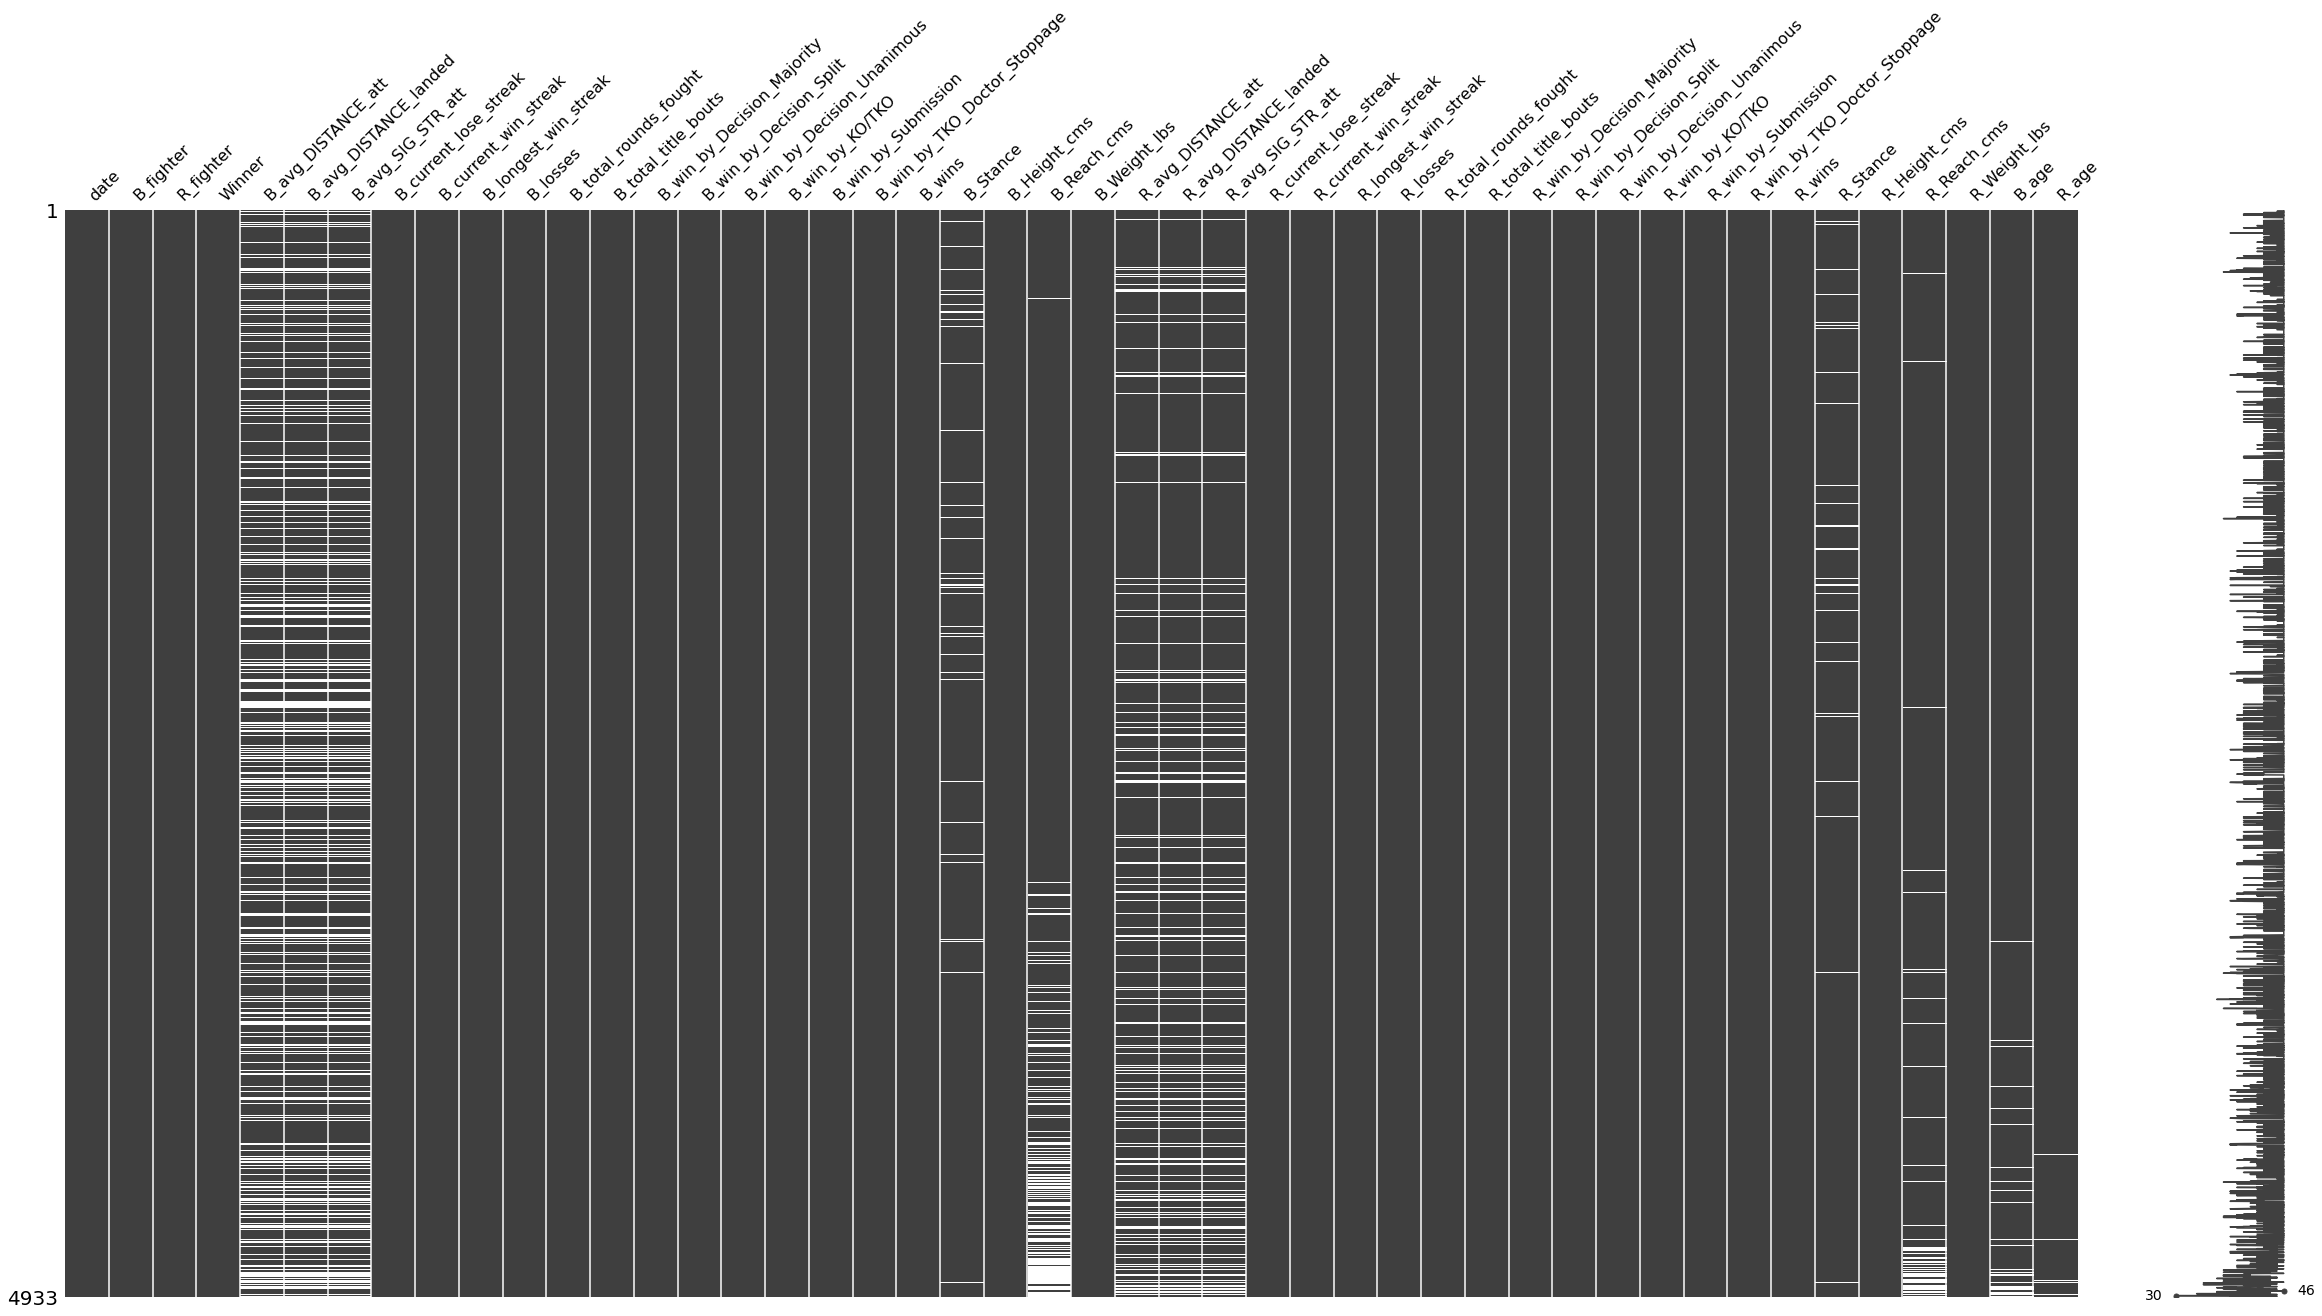

In [51]:
missing = round(ufc_data_clean.isnull().sum()/ufc_data_clean.shape[0]*100,2)
print(f'% Missing in {len(missing[missing > 0])} Features:\n{missing[missing > 0]}')
msno.matrix(ufc_data_clean,figsize=(40,20))

Função pra converter Pés e Polegadas para cm

In [90]:
ufc_data[ufc_data['B_fighter'] == "Anderson Silva"]

R_fighter       B_fighter        Referee       date  \
39    Jared Cannonier  Anderson Silva      Herb Dean 2019-05-11   
186   Israel Adesanya  Anderson Silva      Herb Dean 2019-02-09   
1408   Daniel Cormier  Anderson Silva  John McCarthy 2016-07-09   
2617    Chris Weidman  Anderson Silva      Herb Dean 2013-12-28   

                                    location Winner  title_bout  \
39    Rio de Janeiro, Rio de Janeiro, Brazil      1       False   
186           Melbourne, Victoria, Australia      1       False   
1408                  Las Vegas, Nevada, USA      1       False   
2617                  Las Vegas, Nevada, USA      1        True   

           weight_class  no_of_rounds  B_current_lose_streak  \
39         Middleweight             3                    1.0   
186        Middleweight             3                    0.0   
1408  Light Heavyweight             3                    4.0   
2617       Middleweight             5                    1.0   

      B_current_win_streak  B_avg_BODY_att  B_avg_BODY_landed  \
39                     0.0           8.652              6.957   
186                    1.0           8.500              6.909   
1408                   0.0           8.050              6.750   
2617                   0.0           7.000              6.000   

      B_avg_CLINCH_att  B_avg_CLINCH_landed  B_avg_DISTANCE_att  \
39               6.217                5.217              41.739   
186              6.273                5.227              40.591   
1408             6.250                5.300              39.500   
2617             6.294                5.471              26.294   

      B_avg_DISTANCE_landed  B_avg_GROUND_att  B_avg_GROUND_landed  \
39                   22.130             7.913                6.174   
186                  21.955             8.273                6.455   
1408                 21.850             8.850                6.850   
2617                 15.471            10.059                7.824   

      B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  B_avg_LEG_att  \
39            37.913             18.783     0.783          9.304   
186           37.409             18.909     0.818          9.227   
1408          36.850             18.950     0.900          9.700   
2617          27.706             16.059     1.000          7.941   

      B_avg_LEG_landed  B_avg_PASS  B_avg_REV  B_avg_SIG_STR_att  \
39               7.783       0.130      0.043             55.870   
186              7.818       0.136      0.045             55.136   
1408             8.300       0.150      0.050             54.600   
2617             6.706       0.176      0.059             42.647   

      B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_att  \
39                  33.522              0.642          0.261         0.174   
186                 33.636              0.651          0.273         0.182   
1408                34.000              0.669          0.300         0.200   
2617                28.765              0.695          0.353         0.235   

      B_avg_TD_landed  B_avg_TD_pct  B_avg_TOTAL_STR_att  \
39              0.130         0.130               65.348   
186             0.136         0.136               64.909   
1408            0.150         0.150               64.150   
2617            0.176         0.176               52.118   

      B_avg_TOTAL_STR_landed  B_longest_win_streak  B_losses  \
39                    41.913                  16.0       6.0   
186                   42.273                  16.0       5.0   
1408                  42.300                  16.0       4.0   
2617                  37.118                  16.0       1.0   

      B_avg_opp_BODY_att  B_avg_opp_BODY_landed  B_avg_opp_CLINCH_att  \
39                 6.000                  3.304                 5.435   
186                5.273                  3.045                 5.545   
1408               5.350                  3.000                 4.600   
2617               

In [79]:
r = re.compile(r"([0-9]+)' ([0-9]*\.?[0-9]+)\"")
def get_cm(el):
    m = r.match(el)
    if m == None:
        return float('NaN')
    else:
        return (int(m.group(1))*12 + float(m.group(2)))*2.54

In [91]:
def remove_lbs(weight):
    return weight.replace(' lbs.', '')

In [145]:
def remove_quote(to_remove):
    return to_remove.replace('"','')

def get_reach(inch):
    if inch != "":
        return int(inch)*2.54
    else:
        return np.nan

In [217]:
fighter_measures = ufc_raw_fighter[['fighter_name', 'Height', 'Weight', 'Reach']]
fighter_measures['Height'] = fighter_measures['Height'].apply(get_cm)
fighter_measures['Weight'] = fighter_measures['Weight'].apply(remove_lbs)
fighter_measures['Reach'] = fighter_measures['Reach'].fillna('').apply(remove_quote)
fighter_measures['Reach'] = fighter_measures['Reach'].apply(get_reach)
fighter_measures

<ipython-input-217-b6ee7e98ae07>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_measures['Height'] = fighter_measures['Height'].apply(get_cm)
<ipython-input-217-b6ee7e98ae07>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_measures['Weight'] = fighter_measures['Weight'].apply(remove_lbs)
<ipython-input-217-b6ee7e98ae07>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

fighter_name  Height Weight   Reach
0                       AJ Fonseca  162.56    145     NaN
1                      AJ Matthews  180.34    185     NaN
2                         AJ McKee  177.80    145     NaN
3                        AJ Siscoe  170.18    135     NaN
4                       Aalon Cruz  182.88    145     NaN
5                      Aaron Brink  190.50    205     NaN
6                        Aaron Ely  172.72    135     NaN
7                    Aaron Jeffery  187.96    185     NaN
9                     Aaron Miller  175.26    145     NaN
10                  Aaron Phillips  175.26    135  177.80
11                     Aaron Riley  172.72    155  175.26
12                      Aaron Rosa  193.04    205  198.12
13                   Aaron Simpson  182.88    170  185.42
14                  Aaron Trujillo  165.10    125     NaN
16                 Aaron Wilkinson  177.80    155     NaN
17            Abdul Razak Alhassan  177.80    170  185.42
18              Abdul-Kerim Edilov  187.96    205  198.12
19                     Abel Cullum  170.18    139     NaN
20                   Abel Trujillo  172.72    155  177.80
21                  Abner Lloveras  180.34    155  180.34
22                 Abongo Humphrey  180.34    205     NaN
23                    Abram Torres  177.80    170     NaN
24                     Abu Azaitar  175.26    185  193.04
25                Achmed Labasanov  190.50    215     NaN
26                    Adam Antolin  165.10    125  160.02
27                      Adam Cella  187.96    170  198.12
28                     Adam Hunter  185.42    185  185.42
29                    Adam Khaliev  182.88    170     NaN
30                       Adam Lynn  177.80    155     NaN
31                   Adam Meredith  187.96    170     NaN
32                   Adam Milstead  190.50    205  193.04
33                 Adam Piccolotti  180.34    155     NaN
34                  Adam Schindler  172.72    155     NaN
37                  Adam Wieczorek  195.58    250  205.74
38                    Adam Yandiev  175.26    185  187.96
39                     Adin Duenas  167.64    145     NaN
40                    Adlan Amagov  187.96    170  193.04
42                     Adrian Diaz  177.80    145     NaN
43                  Adrian Serrano  172.72    170     NaN
44                 Adriano Martins  177.80    155  182.88
46                Adrienna Jenkins  172.72    145     NaN
47                  Aiemann Zahabi  172.72    135  172.72
48                    Aisling Daly  157.48    115  162.56
49                      Aji Susilo  177.80    155     NaN
50                  Akbarh Arreola  177.80    155  180.34
51                    Akihiro Gono  170.18    170  172.72
53                 Akira Corassani  172.72    145  172.72
54                   Akira Kikuchi  172.72    155     NaN
55                     Akira Shoji  172.72    195     NaN
56                 Akitoshi Tamura  175.26    135  177.80
57                  Akiyo Nishiura  172.72    139     NaN
58                     Al Iaquinta  177.80    155  177.80
59                    Alan Belcher  187.96    185  185.42
61                       Alan Hiro  165.10    135     NaN
62                     Alan Jouban  182.88    170  185.42
63                       Alan Omer  177.80    145  180.34
64                    Alan Patrick  180.34    155  187.96
65               Alavutdin Gadjiev  187.96    185     NaN
66                    Albert Cheng  180.34    170     NaN
67                  Albert Morales  175.26    135  182.88
68                     Albert Rios  172.72    145     NaN
69                  Albert Tumenov  180.34    170  185.42
70              Alberta Cerra Leon  172.72    238     NaN
71                   Alberto Crane  165.10    155     NaN
72                    Alberto Mina  182.88    170  195.58
73                     Alberto Uda  190.50    185  195.58
74                Alejandro Garcia  170.18    145     NaN
75                 Alejandro Perez  167.64    135  170.18
76            Alejan

In [218]:
fighter_measures_predict = fighter_measures.dropna()
fighter_measures_predict

fighter_name  Height Weight   Reach
10                  Aaron Phillips  175.26    135  177.80
11                     Aaron Riley  172.72    155  175.26
12                      Aaron Rosa  193.04    205  198.12
13                   Aaron Simpson  182.88    170  185.42
17            Abdul Razak Alhassan  177.80    170  185.42
18              Abdul-Kerim Edilov  187.96    205  198.12
20                   Abel Trujillo  172.72    155  177.80
21                  Abner Lloveras  180.34    155  180.34
24                     Abu Azaitar  175.26    185  193.04
26                    Adam Antolin  165.10    125  160.02
27                      Adam Cella  187.96    170  198.12
28                     Adam Hunter  185.42    185  185.42
32                   Adam Milstead  190.50    205  193.04
37                  Adam Wieczorek  195.58    250  205.74
38                    Adam Yandiev  175.26    185  187.96
40                    Adlan Amagov  187.96    170  193.04
44                 Adriano Martins  177.80    155  182.88
47                  Aiemann Zahabi  172.72    135  172.72
48                    Aisling Daly  157.48    115  162.56
50                  Akbarh Arreola  177.80    155  180.34
51                    Akihiro Gono  170.18    170  172.72
53                 Akira Corassani  172.72    145  172.72
56                 Akitoshi Tamura  175.26    135  177.80
58                     Al Iaquinta  177.80    155  177.80
59                    Alan Belcher  187.96    185  185.42
62                     Alan Jouban  182.88    170  185.42
63                       Alan Omer  177.80    145  180.34
64                    Alan Patrick  180.34    155  187.96
67                  Albert Morales  175.26    135  182.88
69                  Albert Tumenov  180.34    170  185.42
72                    Alberto Mina  182.88    170  195.58
73                     Alberto Uda  190.50    185  195.58
75                 Alejandro Perez  167.64    135  170.18
78                Aleksandar Rakic  193.04    205  198.12
80               Aleksei Kunchenko  172.72    170  177.80
81                 Aleksei Oleinik  187.96    240  203.20
82                  Alen Amedovski  177.80    185  187.96
83                Alessandro Ricci  180.34    155  175.26
84              Alessio Di Chirico  182.88    185  187.96
85                  Alessio Sakara  182.88    185  182.88
87                    Alex Caceres  177.80    145  185.42
88                   Alex Chambers  160.02    115  160.02
90                   Alex Da Silva  172.72    155  185.42
92                     Alex Enlund  177.80    145  185.42
93                     Alex Garcia  175.26    170  182.88
94                     Alex Gilpin  170.18    145  182.88
95                    Alex Gorgees  187.96    155  187.96
99                  Alex Karalexis  172.72    155  167.64
100                    Alex Morono  180.34    170  182.88
101                 Alex Nicholson  193.04    185  205.74
102                  Alex Oliveira  180.34    170  193.04
103                     Alex Perez  167.64    135  165.10
104                     Alex Reyes  180.34    170  185.42
106                 Alex Serdyukov  187.96    170  187.96
107                      Alex Soto  172.72    135  180.34
109                    Alex Torres  177.80    145  177.80
110                     Alex White  182.88    155  180.34
112                   Alexa Grasso  165.10    115  167.64
114           Alexander Gustafsson  195.58    205  200.66
115            Alexander Hernandez  175.26    155  182.88
123          Alexander Volkanovski  167.64    145  180.34
124               Alexander Volkov  200.66    250  203.20
125             Alexander Yakovlev  190.50    155  187.96
126                 Alexandra Albu  157.48    115  160.02
131              Alexandre Pantoja  165.10    125  170.18
133                   Alexis Davis  167.64    125  172.72
134                Alexis Dufresne  175.26    135  172.72
136              Alfred Khashakyan  172.72    135  177.80
137                 

In [219]:
fighter_measures['Weight'] = fighter_measures['Weight'].astype(float)
fighter_measures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3044 entries, 0 to 3312
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fighter_name  3044 non-null   object 
 1   Height        3044 non-null   float64
 2   Weight        3044 non-null   float64
 3   Reach         1568 non-null   float64
dtypes: float64(3), object(1)
memory usage: 198.9+ KB


<ipython-input-219-11de713c86fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fighter_measures['Weight'] = fighter_measures['Weight'].astype(float)


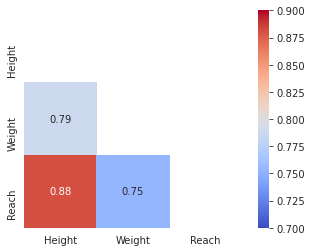

In [155]:
# correlation heatmap
corr = fighter_measures_predict.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(corr, mask=mask, vmin=0.7,vmax=0.9,center=0.8, square=True, annot=True,cmap="coolwarm")

In [243]:
# Missing Value Treatment:
# 2- predict reach based on height via Linear Regression

X = fighter_measures_predict['Height'].values.reshape(-1,1)
y = fighter_measures_predict['Reach'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
lm = LinearRegression()  
lm.fit(X_train, y_train) #training the algorithm


LinearRegression()

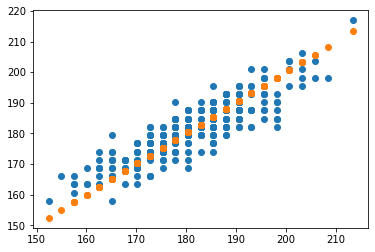

In [244]:
predictions = lm.predict(X_test)

plt.scatter(y_test[:],predictions[:])
plt.scatter(y_test[:],y_test[:])

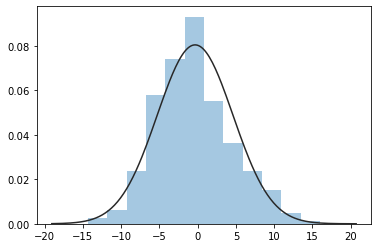

In [261]:
sns.distplot((y_test-predictions),bins=12,fit=norm, kde=False);

In [270]:
fighter_measures_predict.columns
# coeficientes = pd.DataFrame(lm.coef_,X.columns)
# coeficientes.columns = ['Coefs']
# coeficientes

Index(['fighter_name', 'Height', 'Weight', 'Reach'], dtype='object')

Quanto menor melhor

In [265]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.9223285372879144
MSE: 24.649623775345397
RMSE: 4.964838746157361


In [ ]:
# replace nan in 'reach' using LR
X_predict = fighter_measures['Height'][pd.isna(fighter_measures['Reach'])].values.reshape(-1,1)
X_predict
y_predict = lm.predict(X_predict)
y_predict

In [227]:
df = pd.DataFrame(data=y_predict, columns=['Reach'])
fighter_measures["Reach_predicted"] = ""
fighter_measures["Reach_predicted"][pd.isna(fighter_measures["Reach"])] = df['Reach']
fighter_measures

fighter_name  Height  Weight   Reach Reach_predicted
0                       AJ Fonseca  162.56   145.0     NaN         166.046
1                      AJ Matthews  180.34   185.0     NaN         184.802
2                         AJ McKee  177.80   145.0     NaN         182.122
3                        AJ Siscoe  170.18   135.0     NaN         174.084
4                       Aalon Cruz  182.88   145.0     NaN         187.481
5                      Aaron Brink  190.50   205.0     NaN         195.519
6                        Aaron Ely  172.72   135.0     NaN         176.763
7                    Aaron Jeffery  187.96   185.0     NaN          192.84
9                     Aaron Miller  175.26   145.0     NaN         168.725
10                  Aaron Phillips  175.26   135.0  177.80                
11                     Aaron Riley  172.72   155.0  175.26                
12                      Aaron Rosa  193.04   205.0  198.12                
13                   Aaron Simpson  182.88   170.0  185.42                
14                  Aaron Trujillo  165.10   125.0     NaN         195.519
16                 Aaron Wilkinson  177.80   155.0     NaN         182.122
17            Abdul Razak Alhassan  177.80   170.0  185.42                
18              Abdul-Kerim Edilov  187.96   205.0  198.12                
19                     Abel Cullum  170.18   139.0     NaN         176.763
20                   Abel Trujillo  172.72   155.0  177.80                
21                  Abner Lloveras  180.34   155.0  180.34                
22                 Abongo Humphrey  180.34   205.0     NaN         176.763
23                    Abram Torres  177.80   170.0     NaN         176.763
24                     Abu Azaitar  175.26   185.0  193.04                
25                Achmed Labasanov  190.50   215.0     NaN         176.763
26                    Adam Antolin  165.10   125.0  160.02                
27                      Adam Cella  187.96   170.0  198.12                
28                     Adam Hunter  185.42   185.0  185.42                
29                    Adam Khaliev  182.88   170.0     NaN          192.84
30                       Adam Lynn  177.80   155.0     NaN         184.802
31                   Adam Meredith  187.96   170.0     NaN         176.763
32                   Adam Milstead  190.50   205.0  193.04                
33                 Adam Piccolotti  180.34   155.0     NaN         168.725
34                  Adam Schindler  172.72   155.0     NaN         174.084
37                  Adam Wieczorek  195.58   250.0  205.74                
38                    Adam Yandiev  175.26   185.0  187.96                
39                     Adin Duenas  167.64   145.0     NaN         176.763
40                    Adlan Amagov  187.96   170.0  193.04                
42                     Adrian Diaz  177.80   145.0     NaN         179.443
43                  Adrian Serrano  172.72   170.0     NaN         195.519
44                 Adriano Martins  177.80   155.0  182.88                
46                Adrienna Jenkins  172.72   145.0     NaN          190.16
47                  Aiemann Zahabi  172.72   135.0  172.72                
48                    Aisling Daly  157.48   115.0  162.56                
49                      Aji Susilo  177.80   155.0     NaN         184.802
50                  Akbarh Arreola  177.80   155.0  180.34                
51                    Akihiro Gono  170.18   170.0  172.72                
53                 Akira Corassani  172.72   145.0  172.72                
54                   Akira Kikuchi  172.72   155.0     NaN         174.084
55                     Akira Shoji  172.72   195.0     NaN         187.481
56                 Akitoshi Tamura  175.26   135.0  177.80                
57                  Akiyo Nishiura  172.72   139.0     NaN         171.405
58                     Al Iaquinta  177.80   155.0  177.80                
59                    Alan Belcher  187.96   18

In [231]:
def new_reach(r):
    if r[0] != '':
        return r[0]
    else:
        return r[1]

In [232]:
fighter_measures['Reach_final'] = fighter_measures[['Reach', 'Reach_predicted']].fillna('').apply(new_reach, axis=1)
fighter_measures

fighter_name  Height  Weight   Reach Reach_predicted  \
0                       AJ Fonseca  162.56   145.0     NaN         166.046   
1                      AJ Matthews  180.34   185.0     NaN         184.802   
2                         AJ McKee  177.80   145.0     NaN         182.122   
3                        AJ Siscoe  170.18   135.0     NaN         174.084   
4                       Aalon Cruz  182.88   145.0     NaN         187.481   
5                      Aaron Brink  190.50   205.0     NaN         195.519   
6                        Aaron Ely  172.72   135.0     NaN         176.763   
7                    Aaron Jeffery  187.96   185.0     NaN          192.84   
9                     Aaron Miller  175.26   145.0     NaN         168.725   
10                  Aaron Phillips  175.26   135.0  177.80                   
11                     Aaron Riley  172.72   155.0  175.26                   
12                      Aaron Rosa  193.04   205.0  198.12                   
13                   Aaron Simpson  182.88   170.0  185.42                   
14                  Aaron Trujillo  165.10   125.0     NaN         195.519   
16                 Aaron Wilkinson  177.80   155.0     NaN         182.122   
17            Abdul Razak Alhassan  177.80   170.0  185.42                   
18              Abdul-Kerim Edilov  187.96   205.0  198.12                   
19                     Abel Cullum  170.18   139.0     NaN         176.763   
20                   Abel Trujillo  172.72   155.0  177.80                   
21                  Abner Lloveras  180.34   155.0  180.34                   
22                 Abongo Humphrey  180.34   205.0     NaN         176.763   
23                    Abram Torres  177.80   170.0     NaN         176.763   
24                     Abu Azaitar  175.26   185.0  193.04                   
25                Achmed Labasanov  190.50   215.0     NaN         176.763   
26                    Adam Antolin  165.10   125.0  160.02                   
27                      Adam Cella  187.96   170.0  198.12                   
28                     Adam Hunter  185.42   185.0  185.42                   
29                    Adam Khaliev  182.88   170.0     NaN          192.84   
30                       Adam Lynn  177.80   155.0     NaN         184.802   
31                   Adam Meredith  187.96   170.0     NaN         176.763   
32                   Adam Milstead  190.50   205.0  193.04                   
33                 Adam Piccolotti  180.34   155.0     NaN         168.725   
34                  Adam Schindler  172.72   155.0     NaN         174.084   
37                  Adam Wieczorek  195.58   250.0  205.74                   
38                    Adam Yandiev  175.26   185.0  187.96                   
39                     Adin Duenas  167.64   145.0     NaN         176.763   
40                    Adlan Amagov  187.96   170.0  193.04                   
42                     Adrian Diaz  177.80   145.0     NaN         179.443   
43                  Adrian Serrano  172.72   170.0     NaN         195.519   
44                 Adriano Martins  177.80   155.0  182.88                   
46                Adrienna Jenkins  172.72   145.0     NaN          190.16   
47                  Aiemann Zahabi  172.72   135.0  172.72                   
48                    Aisling Daly  157.48   115.0  162.56                   
49                      Aji Susilo  177.80   155.0     NaN         184.802   
50                  Akbarh Arreola  177.80   155.0  180.34                   
51                    Akihiro Gono  170.18   170.0  172.72                   
53                 Akira Corassani  172.72   145.0  172.72                   
54                   Akira Kikuchi  172.72   155.0     NaN         174.084   
55                     Akira Shoji  172.72   195.0     NaN         187.481   
56                 Akitoshi Tamura  175.26   135.0  177.80                   
57                  Akiyo Nishiura  172.72  

In [233]:
del fighter_measures['Reach']
del fighter_measures['Reach_predicted']

In [234]:
fighter_measures

fighter_name  Height  Weight Reach_final
0                       AJ Fonseca  162.56   145.0     166.046
1                      AJ Matthews  180.34   185.0     184.802
2                         AJ McKee  177.80   145.0     182.122
3                        AJ Siscoe  170.18   135.0     174.084
4                       Aalon Cruz  182.88   145.0     187.481
5                      Aaron Brink  190.50   205.0     195.519
6                        Aaron Ely  172.72   135.0     176.763
7                    Aaron Jeffery  187.96   185.0      192.84
9                     Aaron Miller  175.26   145.0     168.725
10                  Aaron Phillips  175.26   135.0       177.8
11                     Aaron Riley  172.72   155.0      175.26
12                      Aaron Rosa  193.04   205.0      198.12
13                   Aaron Simpson  182.88   170.0      185.42
14                  Aaron Trujillo  165.10   125.0     195.519
16                 Aaron Wilkinson  177.80   155.0     182.122
17            Abdul Razak Alhassan  177.80   170.0      185.42
18              Abdul-Kerim Edilov  187.96   205.0      198.12
19                     Abel Cullum  170.18   139.0     176.763
20                   Abel Trujillo  172.72   155.0       177.8
21                  Abner Lloveras  180.34   155.0      180.34
22                 Abongo Humphrey  180.34   205.0     176.763
23                    Abram Torres  177.80   170.0     176.763
24                     Abu Azaitar  175.26   185.0      193.04
25                Achmed Labasanov  190.50   215.0     176.763
26                    Adam Antolin  165.10   125.0      160.02
27                      Adam Cella  187.96   170.0      198.12
28                     Adam Hunter  185.42   185.0      185.42
29                    Adam Khaliev  182.88   170.0      192.84
30                       Adam Lynn  177.80   155.0     184.802
31                   Adam Meredith  187.96   170.0     176.763
32                   Adam Milstead  190.50   205.0      193.04
33                 Adam Piccolotti  180.34   155.0     168.725
34                  Adam Schindler  172.72   155.0     174.084
37                  Adam Wieczorek  195.58   250.0      205.74
38                    Adam Yandiev  175.26   185.0      187.96
39                     Adin Duenas  167.64   145.0     176.763
40                    Adlan Amagov  187.96   170.0      193.04
42                     Adrian Diaz  177.80   145.0     179.443
43                  Adrian Serrano  172.72   170.0     195.519
44                 Adriano Martins  177.80   155.0      182.88
46                Adrienna Jenkins  172.72   145.0      190.16
47                  Aiemann Zahabi  172.72   135.0      172.72
48                    Aisling Daly  157.48   115.0      162.56
49                      Aji Susilo  177.80   155.0     184.802
50                  Akbarh Arreola  177.80   155.0      180.34
51                    Akihiro Gono  170.18   170.0      172.72
53                 Akira Corassani  172.72   145.0      172.72
54                   Akira Kikuchi  172.72   155.0     174.084
55                     Akira Shoji  172.72   195.0     187.481
56                 Akitoshi Tamura  175.26   135.0       177.8
57                  Akiyo Nishiura  172.72   139.0     171.405
58                     Al Iaquinta  177.80   155.0       177.8
59                    Alan Belcher  187.96   185.0      185.42
61                       Alan Hiro  165.10   135.0     182.122
62                     Alan Jouban  182.88   170.0      185.42
63                       Alan Omer  177.80   145.0      180.34
64                    Alan Patrick  180.34   155.0      187.96
65               Alavutdin Gadjiev  187.96   185.0     179.443
66                    Albert Cheng  180.34   170.0     187.481
67                  Albert Morales  175.26   135.0      182.88
68                     Albert Rios  172.72   145.0     187.481
69                  Albert Tumenov  180.34   170.0      185.42
70              Alberta Cerra Leon  172.72   238.0   

In [239]:
ufc_data = pd.merge(ufc_data, fighter_measures[['fighter_name', 'Reach_final']], how='left', left_on='B_fighter', right_on='fighter_name')
del ufc_data['fighter_name']
ufc_data.rename(columns={'Reach_final':'B_Reach_final'},inplace=True)
ufc_data.head()

R_fighter       B_fighter          Referee       date  \
0          Henry Cejudo   Marlon Moraes     Marc Goddard 2019-06-08   
1  Valentina Shevchenko     Jessica Eye  Robert Madrigal 2019-06-08   
2         Tony Ferguson  Donald Cerrone  Dan Miragliotta 2019-06-08   
3         Jimmie Rivera        Petr Yan  Kevin MacDonald 2019-06-08   
4           Tai Tuivasa   Blagoy Ivanov  Dan Miragliotta 2019-06-08   

                 location Winner  title_bout       weight_class  no_of_rounds  \
0  Chicago, Illinois, USA      1        True       Bantamweight             5   
1  Chicago, Illinois, USA      1        True  Women's Flyweight             5   
2  Chicago, Illinois, USA      1       False        Lightweight             3   
3  Chicago, Illinois, USA      0       False       Bantamweight             3   
4  Chicago, Illinois, USA      0       False        Heavyweight             3   

   B_current_lose_streak  B_current_win_streak  B_avg_BODY_att  \
0                    0.0                   4.0           9.200   
1                    0.0                   3.0          14.600   
2                    0.0                   3.0          15.355   
3                    0.0                   4.0          17.000   
4                    0.0                   1.0          17.000   

   B_avg_BODY_landed  B_avg_CLINCH_att  B_avg_CLINCH_landed  \
0              6.000             0.200                0.000   
1              9.100            11.800                7.300   
2             11.323             6.742                4.387   
3             14.000            13.750               11.000   
4             14.500             2.500                2.000   

   B_avg_DISTANCE_att  B_avg_DISTANCE_landed  B_avg_GROUND_att  \
0              62.600                 20.600             2.600   
1             124.700                 42.100             2.400   
2              84.742                 38.581             5.516   
3             109.500                 48.750            13.000   
4             201.000                 59.500             0.000   

   B_avg_GROUND_landed  B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  \
0                2.000          48.600             11.200     0.800   
1                1.900         112.000             32.000     0.000   
2                3.806          67.645             23.258     0.645   
3               10.500         116.250             53.750     0.500   
4                0.000         184.500             45.000     0.000   

   B_avg_LEG_att  B_avg_LEG_landed  B_avg_PASS  B_avg_REV  B_avg_SIG_STR_att  \
0            7.6             5.400       0.400      0.000              65.40   
1           12.3            10.200       0.800      0.000             138.90   
2           14.0            12.194       0.935      0.097              97.00   
3            3.0             2.500       0.500      0.250             136.25   
4            2.0             2.000       0.000      0.000             203.50   

   B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_att  \
0                22.600              0.466          0.400         0.800   
1                51.300              0.399          0.700         1.000   
2                46.774              0.496          0.355         2.161   
3                70.250              0.550          0.250         2.500   
4                61.500              0.310          0.000         0.000   

   B_avg_TD_landed  B_avg_TD_pct  B_avg_TOTAL_STR_att  B_avg_TOTAL_STR_landed  \
0            0.200         0.100                66.40                  23.600   
1            0.500         0.225               158.70                  69.600   
2            0.677         0.295               103.71                  52.548   
3            1.250         0.288               154.75                  86.750   
4            0.000         0.000               204.00                  62.000   

   B_longest_win_streak  B_losses  B_avg_opp_BODY_att  B_avg_opp_BODY_landed  \
0

In [240]:
ufc_data = pd.merge(ufc_data, fighter_measures[['fighter_name', 'Reach_final']], how='left', left_on='R_fighter', right_on='fighter_name')
del ufc_data['fighter_name']
ufc_data.rename(columns={'Reach_final':'R_Reach_final'},inplace=True)
ufc_data.head()

R_fighter       B_fighter          Referee       date  \
0          Henry Cejudo   Marlon Moraes     Marc Goddard 2019-06-08   
1  Valentina Shevchenko     Jessica Eye  Robert Madrigal 2019-06-08   
2         Tony Ferguson  Donald Cerrone  Dan Miragliotta 2019-06-08   
3         Jimmie Rivera        Petr Yan  Kevin MacDonald 2019-06-08   
4           Tai Tuivasa   Blagoy Ivanov  Dan Miragliotta 2019-06-08   

                 location Winner  title_bout       weight_class  no_of_rounds  \
0  Chicago, Illinois, USA      1        True       Bantamweight             5   
1  Chicago, Illinois, USA      1        True  Women's Flyweight             5   
2  Chicago, Illinois, USA      1       False        Lightweight             3   
3  Chicago, Illinois, USA      0       False       Bantamweight             3   
4  Chicago, Illinois, USA      0       False        Heavyweight             3   

   B_current_lose_streak  B_current_win_streak  B_avg_BODY_att  \
0                    0.0                   4.0           9.200   
1                    0.0                   3.0          14.600   
2                    0.0                   3.0          15.355   
3                    0.0                   4.0          17.000   
4                    0.0                   1.0          17.000   

   B_avg_BODY_landed  B_avg_CLINCH_att  B_avg_CLINCH_landed  \
0              6.000             0.200                0.000   
1              9.100            11.800                7.300   
2             11.323             6.742                4.387   
3             14.000            13.750               11.000   
4             14.500             2.500                2.000   

   B_avg_DISTANCE_att  B_avg_DISTANCE_landed  B_avg_GROUND_att  \
0              62.600                 20.600             2.600   
1             124.700                 42.100             2.400   
2              84.742                 38.581             5.516   
3             109.500                 48.750            13.000   
4             201.000                 59.500             0.000   

   B_avg_GROUND_landed  B_avg_HEAD_att  B_avg_HEAD_landed  B_avg_KD  \
0                2.000          48.600             11.200     0.800   
1                1.900         112.000             32.000     0.000   
2                3.806          67.645             23.258     0.645   
3               10.500         116.250             53.750     0.500   
4                0.000         184.500             45.000     0.000   

   B_avg_LEG_att  B_avg_LEG_landed  B_avg_PASS  B_avg_REV  B_avg_SIG_STR_att  \
0            7.6             5.400       0.400      0.000              65.40   
1           12.3            10.200       0.800      0.000             138.90   
2           14.0            12.194       0.935      0.097              97.00   
3            3.0             2.500       0.500      0.250             136.25   
4            2.0             2.000       0.000      0.000             203.50   

   B_avg_SIG_STR_landed  B_avg_SIG_STR_pct  B_avg_SUB_ATT  B_avg_TD_att  \
0                22.600              0.466          0.400         0.800   
1                51.300              0.399          0.700         1.000   
2                46.774              0.496          0.355         2.161   
3                70.250              0.550          0.250         2.500   
4                61.500              0.310          0.000         0.000   

   B_avg_TD_landed  B_avg_TD_pct  B_avg_TOTAL_STR_att  B_avg_TOTAL_STR_landed  \
0            0.200         0.100                66.40                  23.600   
1            0.500         0.225               158.70                  69.600   
2            0.677         0.295               103.71                  52.548   
3            1.250         0.288               154.75                  86.750   
4            0.000         0.000               204.00                  62.000   

   B_longest_win_streak  B_losses  B_avg_opp_BODY_att  B_avg_opp_BODY_landed  \
0

In [242]:
ufc_data['B_Reach_cms'] = ufc_data[['B_Reach_cms', 'B_Reach_final']].fillna('').apply(new_reach, axis=1)
ufc_data['R_Reach_cms'] = ufc_data[['R_Reach_cms', 'R_Reach_final']].fillna('').apply(new_reach, axis=1)
del ufc_data['B_Reach_final']
del ufc_data['R_Reach_final']
ufc_data.head()

KeyError: "['B_Reach_final'] not in index"